# BASIC AI AGENTS STRUCTURE

## Imports and configurations

Create `.env` file with:
```
OPENAI_API_KEY=YOUR_KEY
```
Make sure you are able to install all necessary libraries

In [38]:
%pip install langchain langgraph langchain-openai openai tiktoken pandas numpy pydantic python-dotenv rich faker seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [39]:
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger("MAS-Pipeline")

In [40]:
from dotenv import load_dotenv
import os, json, re
import pandas as pd
import numpy as np
from pydantic import BaseModel, ValidationError, Field, confloat, constr

from typing import List, Optional, Literal, Dict, Any, Union
from rich import print as rprint

import random
from faker import Faker
from datetime import datetime, timedelta, date

# Updated imports for LangChain v0.2+
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# OpenAI LLM import
from langchain_openai import ChatOpenAI

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Set up clean, consistent plotting style
sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (10, 5)

# Load env vars
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

MODEL_NAME = "gpt-4o-mini"
assert OPENAI_API_KEY, "Set OPENAI_API_KEY env var in .env"

llm = ChatOpenAI(
    api_key=OPENAI_API_KEY,
    model_name=MODEL_NAME,
    temperature=0,
    max_tokens=700
)

rprint(f"[bold green]OpenAI (LangChain) ready with model: {MODEL_NAME}[/bold green]")


OpenAI (LangChain) ready with model: gpt-4o-mini

## Generate fake datasets to study

In [41]:
fake = Faker()
Faker.seed(42)
np.random.seed(42)
random.seed(42)


def generate_customers(n_customers: int = 100) -> pd.DataFrame:
    customer_ids = [f"CUST-{1000+i}" for i in range(n_customers)]
    countries = ["US", "UK", "DE", "PT", "IN", "SG", "NG", "BR", "AE", "RU"]
    country_probs = [0.8, 0.05, 0.025, 0.05, 0.025, 0.01, 0.01, 0.01, 0.01, 0.01]

    def generate_balance(kyc_level, country):
        base = {"basic": 7, "simplified": 8, "enhanced": 9}
        mean = base[kyc_level]
        sigma = 0.8
        if country in ["US", "UK", "DE", "SG", "AE"]:
            mean += 0.3
        return np.random.lognormal(mean, sigma)

    kyc_levels = np.random.choice(["basic", "enhanced", "simplified"], size=n_customers, p=[0.4, 0.4, 0.2])
    countries = np.random.choice(countries, p=country_probs, size=n_customers)
    balances = [round(generate_balance(k, c), 2) for k, c in zip(kyc_levels, countries)]

    data = {
        "customer_id": customer_ids,
        "name": [fake.name() for _ in range(n_customers)],
        "dob": [fake.date_of_birth(minimum_age=18, maximum_age=80) for _ in range(n_customers)],
        "country": countries,
        "kyc_level": kyc_levels,
        "account_open_date": [fake.date_between(start_date="-5y", end_date="today") for _ in range(n_customers)],
        "balance_usd": balances,
    }
    return pd.DataFrame(data)


def generate_crypto_activity(customers: pd.DataFrame, n_wallets: int = 20) -> pd.DataFrame:
    wallet_ids = [f"WALLET-{i:05d}" for i in range(n_wallets)]
    assets = ["BTC", "ETH", "XRP", "SOL", "ADA", "DOGE"]
    asset_probs = [0.3, 0.25, 0.2, 0.1, 0.1, 0.05]
    chosen_assets = np.random.choice(assets, p=asset_probs, size=n_wallets)
    balances = np.random.lognormal(mean=2, sigma=1.2, size=n_wallets)
    on_chain_tx_count = np.random.poisson(lam=balances * 2)
    crypto_customers = np.random.choice(customers["customer_id"], size=n_wallets, replace=False)

    data = {
        "wallet_id": wallet_ids,
        "customer_id": crypto_customers,
        "crypto_asset": chosen_assets,
        "wallet_address": [fake.sha256(raw_output=False)[:20] for _ in range(n_wallets)],
        "balance": np.round(balances, 4),
        "on_chain_tx_count": on_chain_tx_count,
    }
    return pd.DataFrame(data)


def generate_transactions(customers: pd.DataFrame, crypto_customers: pd.Series, n_trx: int = 5000) -> pd.DataFrame:
    trx_ids = [f"TX-{100000+i}" for i in range(n_trx)]
    fiat_currencies = ["USD", "EUR", "GBP"]
    fiat_probs = [0.8, 0.15, 0.05]
    crypto_currencies = ["BTC", "ETH", "XRP", "SOL", "ADA", "DOGE"]
    trx_types = ["deposit", "withdrawal", "transfer", "crypto_buy", "crypto_sell"]

    start_date = datetime.now() - timedelta(days=365)
    hour_probs = np.array([
        0.001,0.001,0.001,0.005,0.01,0.05,0.1,0.1,
        0.1,0.1,0.05,0.05,0.05,0.05,0.05,0.1,
        0.1,0.1,0.05,0.01,0.005,0.001,0.001,0.001
    ], dtype=float)
    hour_probs /= hour_probs.sum()
    hour_probs[-1] = 1.0 - hour_probs[:-1].sum()

    timestamps = [
        start_date + timedelta(
            days=random.randint(0,365),
            hours=int(np.random.choice(range(24), p=hour_probs))
        )
        for _ in range(n_trx)
    ]

    tx_type_values = np.random.choice(trx_types, size=n_trx, p=[0.35,0.3,0.25,0.05,0.05])

    customer_ids = []
    currencies = []
    receiver_ids = []
    for tt in tx_type_values:
        if tt in ["crypto_buy", "crypto_sell"]:
            cid = np.random.choice(crypto_customers)
            customer_ids.append(cid)
            receiver_ids.append(None)  # no receiver for crypto buy/sell
            currencies.append(np.random.choice(crypto_currencies))
        elif tt == "transfer":
            cid = np.random.choice(customers["customer_id"])
            customer_ids.append(cid)
            # Receiver must be different customer
            possible_receivers = customers[customers["customer_id"] != cid]["customer_id"]
            receiver_ids.append(np.random.choice(possible_receivers))
            currencies.append(np.random.choice(fiat_currencies, p=fiat_probs))
        else:
            cid = np.random.choice(customers["customer_id"])
            customer_ids.append(cid)
            receiver_ids.append(None)
            currencies.append(np.random.choice(fiat_currencies, p=fiat_probs))

    trx_type_params = {
        "deposit": (8,0.8),
        "withdrawal": (7.5,0.9),
        "transfer": (8,1.0),
        "crypto_buy": (9,1.2),
        "crypto_sell": (9,1.1)
    }
    amounts = [np.random.lognormal(*trx_type_params[tt]) for tt in tx_type_values]

    desc_map = {
        "deposit": ["Salary payment", "Freelance project payout", "Refund from online purchase",
                    "Bank deposit via ATM", "Investment income credit", "Cash deposit at branch"],
        "withdrawal": ["ATM cash withdrawal", "Online purchase at Amazon", "Utility bill payment",
                       "Debit card transaction", "Rent payment", "Credit card bill payment"],
        "transfer": ["Transfer to family account", "Wire transfer to offshore entity", "Peer-to-peer transfer",
                     "Payment for services", "Internal transfer between accounts", "Transfer to business partner"],
        "crypto_buy": ["Crypto purchase via Coinbase", "Buy order on Binance", "Converted USD to BTC",
                       "Bought ETH for staking", "Crypto top-up using card"],
        "crypto_sell": ["Sold BTC for USD", "Converted ETH to USDT", "Crypto liquidation transaction",
                        "Payout from exchange wallet", "Sale of digital assets"]
    }
    descriptions = [random.choice(desc_map[tt]) for tt in tx_type_values]

    data = {
        "trx_id": trx_ids,
        "timestamp": timestamps,
        "customer_id": customer_ids,
        "receiver_id": receiver_ids,
        "currency": currencies,
        "amount": np.round(amounts,2),
        "trx_type": tx_type_values,
        "description": descriptions
    }
    return pd.DataFrame(data)


# Generate datasets
customers = generate_customers()
crypto = generate_crypto_activity(customers, n_wallets=30)
crypto_customers = crypto["customer_id"].unique()
trx = generate_transactions(customers, crypto_customers)

# Validation
crypto_tx = trx[trx["trx_type"].isin(["crypto_buy","crypto_sell"])]
invalid_crypto_tx = crypto_tx[~crypto_tx["customer_id"].isin(crypto_customers)]
print(f"Invalid crypto transactions: {len(invalid_crypto_tx)}")

transfer_tx = trx[trx["trx_type"]=="transfer"]
print(f"Transfers with valid receivers: {transfer_tx['receiver_id'].notnull().all()}")

print(f"Crypto transactions (len:{len(trx[trx["trx_type"].isin(["crypto_buy","crypto_sell"])])}) currencies:") 
print(trx[trx["trx_type"].isin(["crypto_buy","crypto_sell"])]["currency"].unique()) 
print(f"Fiat transactions (len:{len(trx[~trx["trx_type"].isin(["crypto_buy","crypto_sell"])])}) currencies:") 
print(trx[~trx["trx_type"].isin(["crypto_buy","crypto_sell"])]["currency"].unique())


Invalid crypto transactions: 0
Transfers with valid receivers: True
Crypto transactions (len:480) currencies:
[np.str_('BTC') np.str_('ETH') np.str_('XRP') np.str_('ADA')
 np.str_('DOGE') np.str_('SOL')]
Fiat transactions (len:4520) currencies:
[np.str_('USD') np.str_('EUR') np.str_('GBP')]


## EDA

In [42]:
# Familiarize with the data
print("CUSTOMERS DATA")
print(customers.head())
print("\n")
print(customers.dtypes)
print("\n\n")
print("TRANSACTIONS DATA")
print(trx.head())
print("\n")
print(trx.dtypes)
print("\n\n")
print("CRYPTO DATA")
print(crypto.head())
print("\n")
print(crypto.dtypes)
print("\n\n")

CUSTOMERS DATA
  customer_id             name         dob country   kyc_level  \
0   CUST-1000     Allison Hill  1981-12-25      US       basic   
1   CUST-1001      Noah Rhodes  1947-04-23      US  simplified   
2   CUST-1002  Angie Henderson  2001-08-25      US    enhanced   
3   CUST-1003    Daniel Wagner  1969-12-24      US    enhanced   
4   CUST-1004  Cristian Santos  1984-06-30      PT       basic   

  account_open_date  balance_usd  
0        2023-02-10       859.18  
1        2021-03-06      4845.49  
2        2021-10-10     13828.10  
3        2024-07-20      6176.57  
4        2023-10-18      4878.63  


customer_id           object
name                  object
dob                   object
country               object
kyc_level             object
account_open_date     object
balance_usd          float64
dtype: object



TRANSACTIONS DATA
      trx_id                  timestamp customer_id receiver_id currency  \
0  TX-100000 2025-10-03 12:07:16.963409   CUST-1091        Non

CUSTOMER DATA OVERVIEW


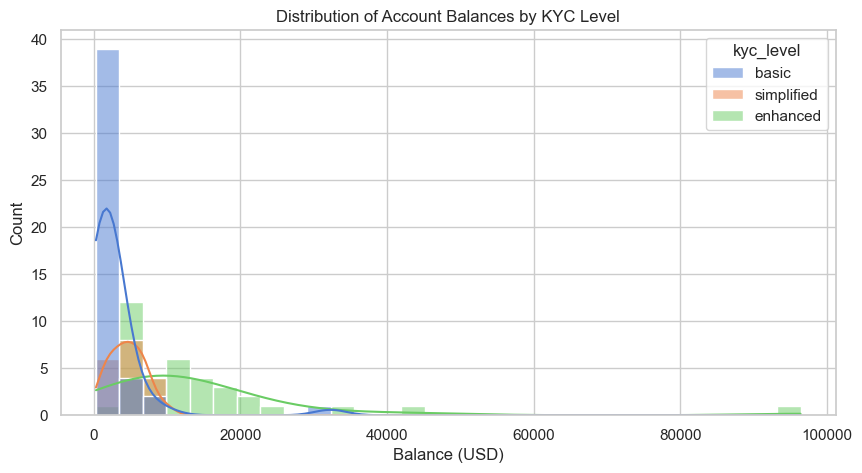

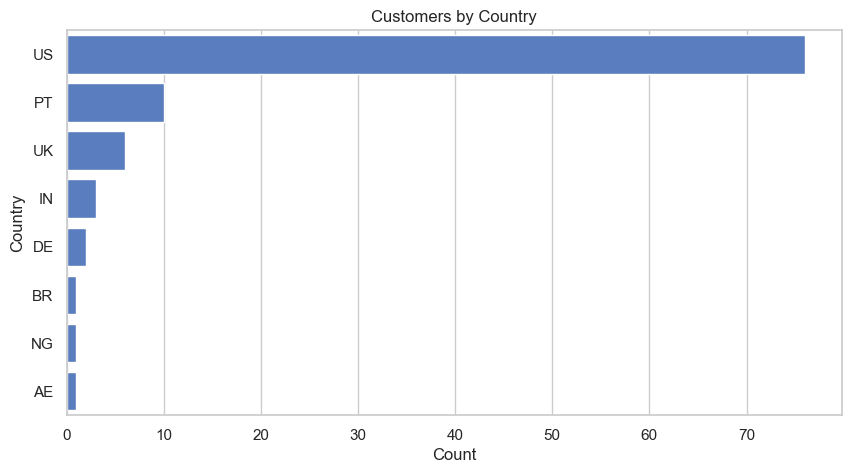

In [43]:
print("CUSTOMER DATA OVERVIEW")

# Balance distribution by KYC level
sns.histplot(data=customers, x="balance_usd", hue="kyc_level", kde=True, bins=30)
plt.title("Distribution of Account Balances by KYC Level")
plt.xlabel("Balance (USD)")
plt.ylabel("Count")
plt.show()

# Country distribution
sns.countplot(data=customers, y="country", order=customers["country"].value_counts().index)
plt.title("Customers by Country")
plt.xlabel("Count")
plt.ylabel("Country")
plt.show()

TRANSACTION DATA OVERVIEW


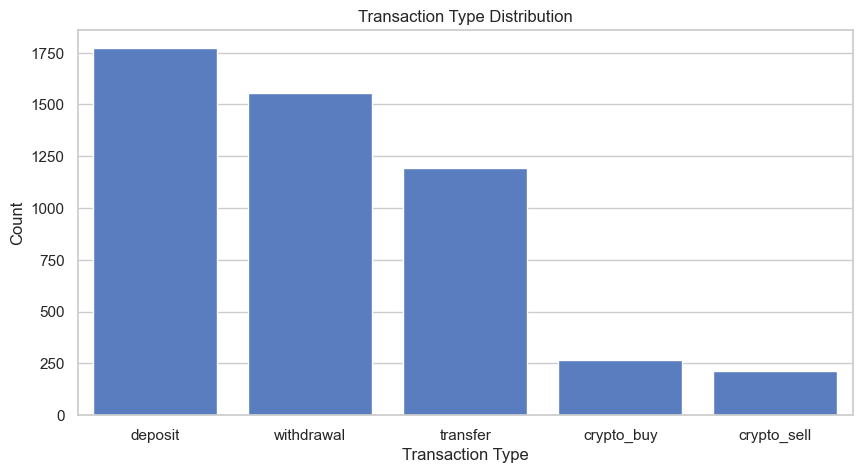

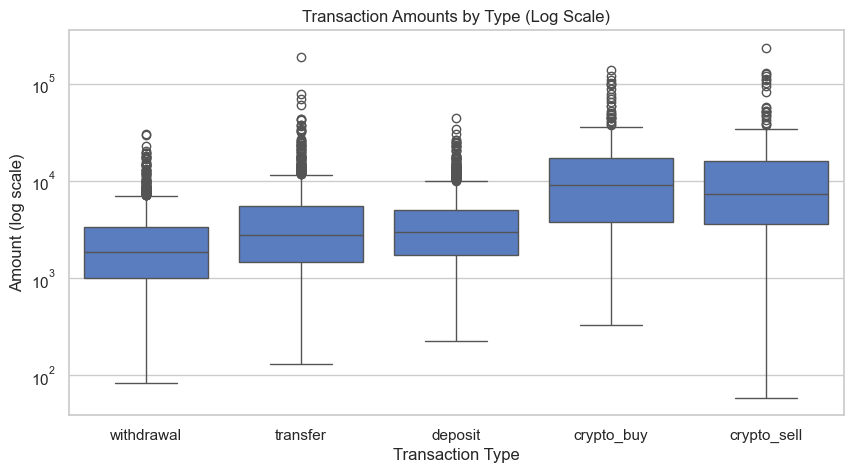

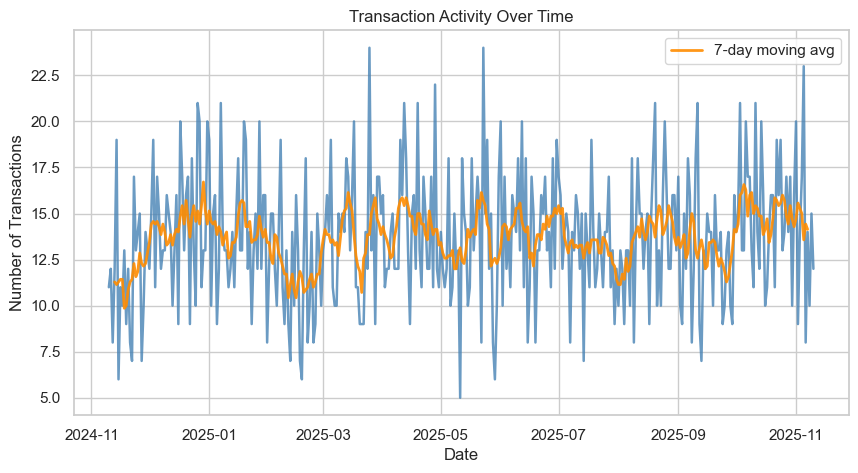

In [44]:
print("TRANSACTION DATA OVERVIEW")

# Transaction type frequency
sns.countplot(data=trx, x="trx_type", order=trx["trx_type"].value_counts().index)
plt.title("Transaction Type Distribution")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

# Transaction amount distribution (log scale for realism)
sns.boxplot(data=trx, x="trx_type", y="amount")
plt.yscale("log")
plt.title("Transaction Amounts by Type (Log Scale)")
plt.xlabel("Transaction Type")
plt.ylabel("Amount (log scale)")
plt.show()

# Time series of transactions
trx["date"] = trx["timestamp"].dt.date
trx_per_day = trx.groupby("date").size()
plt.plot(trx_per_day.index, trx_per_day.values, color="steelblue", linewidth=1.8, alpha=0.8)
plt.plot(trx_per_day.index, trx_per_day.rolling(window=7, center=True).mean(),
         color="darkorange", linewidth=2, alpha=0.9, label="7-day moving avg")
plt.title("Transaction Activity Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.legend()
plt.show()

CRYPTO WALLET DATA OVERVIEW


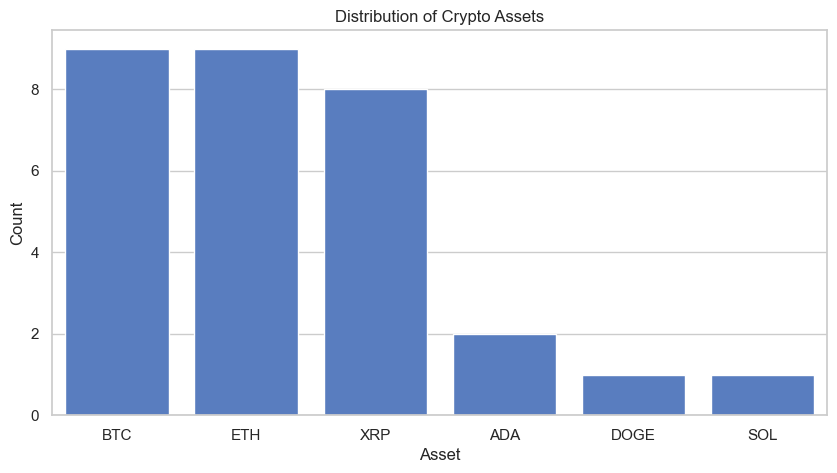

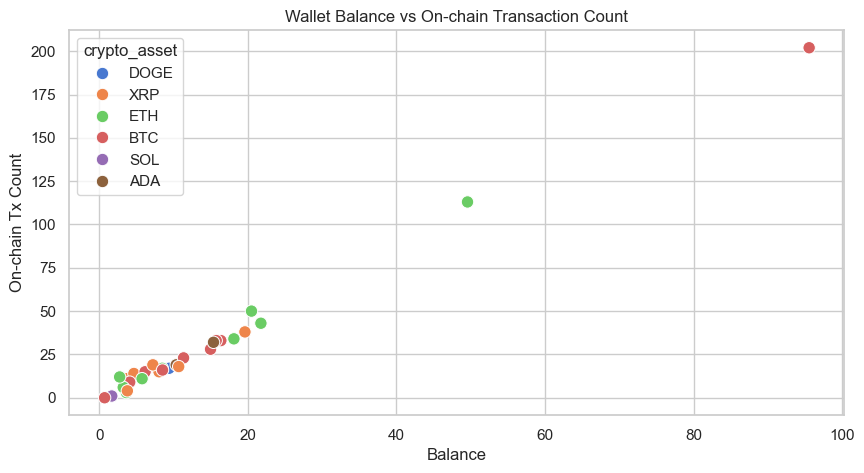

In [45]:
print("CRYPTO WALLET DATA OVERVIEW")

# Crypto asset distribution
sns.countplot(data=crypto, x="crypto_asset", order=crypto["crypto_asset"].value_counts().index)
plt.title("Distribution of Crypto Assets")
plt.xlabel("Asset")
plt.ylabel("Count")
plt.show()

# Wallet balance vs on-chain activity correlation
sns.scatterplot(data=crypto, x="balance", y="on_chain_tx_count", hue="crypto_asset", s=80)
plt.title("Wallet Balance vs On-chain Transaction Count")
plt.xlabel("Balance")
plt.ylabel("On-chain Tx Count")
plt.show()

## Advanced feature engineering

In [46]:
# Amount Z-score
amt_mean = trx['amount'].mean()
amt_std = trx['amount'].std(ddof=0) or 1.0
trx['amount_z'] = (trx['amount'] - amt_mean) / amt_std

# Transaction velocity
trx = trx.sort_values(['customer_id','timestamp'])
trx['c_txn_7d'] = 0
for cid, grp in trx.groupby('customer_id'):
    idxs = grp.index.tolist()
    for i, idx in enumerate(idxs):
        d = grp.loc[idx, 'timestamp']
        n = grp[(grp['timestamp'] >= d - pd.Timedelta(days=7)) & (grp['timestamp'] <= d)].shape[0]
        trx.loc[idx, 'c_txn_7d'] = n

# Keyword flag
kw = re.compile(r"\b(crypto|cash|gift|urgent|refund|invoice split|transfer split|exchange)\b", re.I)
trx['kw_flag'] = trx['description'].fillna("").str.contains(kw).astype(int)

# Transactions to multiple countries flag
customers_country = customers[['customer_id', 'country']].rename(columns={'customer_id': 'receiver_id', 'country': 'receiver_country'})
trx = trx.merge(customers_country, on='receiver_id', how='left')
transfer_tx = trx[trx['trx_type'] == 'transfer']
multi_country = (
    transfer_tx.groupby('customer_id')['receiver_country']
               .nunique()
               .reset_index(name='unique_receiver_countries')
)
multi_country['multi_country_flag'] = (multi_country['unique_receiver_countries'] > 1).astype(int)
trx = trx.merge(
    multi_country[['customer_id', 'multi_country_flag']],
    on='customer_id',
    how='left'
)
trx['multi_country_flag'] = trx['multi_country_flag'].fillna(0).astype(int)

# Structuring flag
trx['month'] = trx['timestamp'].dt.to_period('M')
monthly_small_tx = (
    trx[trx['amount'] < 10_000]
    .groupby(['customer_id', 'month'])
    .size()
    .reset_index(name='small_tx_count')
)

monthly_small_tx['structuring_flag'] = (monthly_small_tx['small_tx_count'] > 10).astype(int)
trx = trx.merge(
    monthly_small_tx[['customer_id', 'month', 'structuring_flag']],
    on=['customer_id', 'month'],
    how='left'
).drop(columns=["month"])
trx['structuring_flag'] = trx['structuring_flag'].fillna(0).astype(int)

# Many transaction types flag
trx_types_per_customer = (
    trx.groupby('customer_id')['trx_type']
       .nunique()
       .reset_index(name='unique_trx_types')
)
trx_types_per_customer['many_trx_types_flag'] = (trx_types_per_customer['unique_trx_types'] >= 4).astype(int)
trx = trx.merge(
    trx_types_per_customer[['customer_id', 'many_trx_types_flag']],
    on='customer_id',
    how='left'
)

# Crypto activity flag
crypto_activity = (
    trx.groupby('customer_id')['trx_type']
       .apply(lambda x: any(t in ['crypto_buy', 'crypto_sell'] for t in x))
       .reset_index(name='crypto_activity_flag')
)
crypto_activity['crypto_activity_flag'] = crypto_activity['crypto_activity_flag'].astype(int)
trx = trx.merge(
    crypto_activity[['customer_id', 'crypto_activity_flag']],
    on='customer_id',
    how='left'
)

# Velocity spike flag
velocity_stats = (
    trx.groupby('customer_id')['c_txn_7d']
       .median()
       .reset_index(name='median_txn_7d')
)
trx = trx.merge(velocity_stats, on='customer_id', how='left')
trx['velocity_spike_flag'] = (trx['c_txn_7d'] > 3 * trx['median_txn_7d']).astype(int)
trx.drop(columns=['median_txn_7d'], inplace=True)

print("Feature engineering complete")
print(trx.head(10))

print("Feature engineering complete")
print("Added features:")
print(trx[['customer_id', 'amount', 'amount_z', 'c_txn_7d', 'kw_flag',
           'multi_country_flag', 'structuring_flag', 'many_trx_types_flag',
           'crypto_activity_flag', 'velocity_spike_flag']].head(10))
print("\n")
print("Current transaction df:")
trx.head(3)

Feature engineering complete
      trx_id                  timestamp customer_id receiver_id currency  \
0  TX-104199 2024-11-10 05:07:16.963409   CUST-1000        None      USD   
1  TX-101231 2024-11-24 15:07:16.963409   CUST-1000        None      USD   
2  TX-100419 2024-12-02 14:07:16.963409   CUST-1000   CUST-1029      EUR   
3  TX-100595 2024-12-17 10:07:16.963409   CUST-1000        None      GBP   
4  TX-102334 2024-12-17 10:07:16.963409   CUST-1000   CUST-1075      USD   
5  TX-104702 2024-12-25 06:07:16.963409   CUST-1000        None      USD   
6  TX-101434 2024-12-26 04:07:16.963409   CUST-1000   CUST-1063      USD   
7  TX-104994 2024-12-28 05:07:16.963409   CUST-1000   CUST-1080      USD   
8  TX-104448 2025-01-24 11:07:16.963409   CUST-1000   CUST-1079      USD   
9  TX-100552 2025-02-07 14:07:16.963409   CUST-1000        None      USD   

     amount    trx_type                   description        date  amount_z  \
0   1639.37  withdrawal                  Rent payment  

C:\Users\AntónioJaneiro\AppData\Local\Temp\ipykernel_30608\470532085.py:18: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  trx['kw_flag'] = trx['description'].fillna("").str.contains(kw).astype(int)


,trx_id,timestamp,customer_id,receiver_id,currency,amount,trx_type,description,date,amount_z,c_txn_7d,kw_flag,receiver_country,multi_country_flag,structuring_flag,many_trx_types_flag,crypto_activity_flag,velocity_spike_flag
0,TX-104199,2024-11-10 05:07:16.963409,CUST-1000,None,USD,1639.37,withdrawal,Rent payment,2024-11-10,-0.348441,1,0,NaN,1,0,0,0,0
1,TX-101231,2024-11-24 15:07:16.963409,CUST-1000,None,USD,2040.77,deposit,Bank deposit via ATM,2024-11-24,-0.305867,1,0,NaN,1,0,0,0,0
2,TX-100419,2024-12-02 14:07:16.963409,CUST-1000,CUST-1029,EUR,2528.42,transfer,Transfer to family account,2024-12-02,-0.254145,1,0,US,1,0,0,0,0


In [47]:
# A look at the new features
list_new_features = ['c_txn_7d', 'kw_flag',
           'multi_country_flag', 'structuring_flag', 'many_trx_types_flag',
           'crypto_activity_flag', 'velocity_spike_flag']
print("CHECK NEW FEATURES VALUE DISTRIBUTIONS:")
for i in list_new_features:
    print(trx[i].value_counts())

CHECK NEW FEATURES VALUE DISTRIBUTIONS:
c_txn_7d
1    1933
2    1822
3     842
4     299
5      81
6      16
7       5
8       1
9       1
Name: count, dtype: int64
kw_flag
0    3971
1    1029
Name: count, dtype: int64
multi_country_flag
1    4787
0     213
Name: count, dtype: int64
structuring_flag
0    4989
1      11
Name: count, dtype: int64
many_trx_types_flag
0    3123
1    1877
Name: count, dtype: int64
crypto_activity_flag
0    3123
1    1877
Name: count, dtype: int64
velocity_spike_flag
0    4985
1      15
Name: count, dtype: int64


## Force native Python datatypes for schemas

In [48]:
# Force native Python strings
trx['currency'] = trx['currency'].map(str)
trx['trx_type'] = trx['trx_type'].map(str)
trx['customer_id'] = trx['customer_id'].map(str)
trx['receiver_id'] = trx['receiver_id'].map(lambda x: str(x) if x is not None else None)
trx['description'] = trx['description'].map(str)
trx['trx_id'] = trx['trx_id'].map(str)

# Force native Python floats
trx['amount'] = trx['amount'].astype(float)
trx['amount_z'] = trx['amount_z'].astype(float)

# Force native Python ints
int_cols = [
    'c_txn_7d', 'kw_flag', 'multi_country_flag', 'structuring_flag',
    'many_trx_types_flag', 'crypto_activity_flag', 'velocity_spike_flag'
]
for col in int_cols:
    trx[col] = trx[col].astype(int)

# Keep only the schema columns
columns_to_keep = [
    'trx_id', 'timestamp', 'customer_id', 'receiver_id', 'currency', 'amount',
    'trx_type', 'description', 'amount_z', 'c_txn_7d', 'kw_flag',
    'multi_country_flag', 'structuring_flag', 'many_trx_types_flag',
    'crypto_activity_flag', 'velocity_spike_flag'
]
trx = trx[columns_to_keep]


## Define data schemas

In [49]:
# Customer schema
class Customer(BaseModel):
    customer_id: constr(pattern=r"^CUST-\d+$") = Field(..., description="Unique customer ID")
    name: str = Field(..., description="Customer full name")
    dob: date = Field(..., description="Date of birth")
    country: str = Field(..., description="Country of residence (ISO or label)")
    kyc_level: Literal["simplified","basic","enhanced"] = Field(..., description="KYC verification level")
    account_open_date: date = Field(..., description="Date when the account was opened")
    balance_usd: confloat(ge=0) = Field(..., description="Current account balance in USD")

# Crypto wallet schema
class Crypto(BaseModel):
    wallet_id: constr(pattern=r"^WALLET-\d+$") = Field(..., description="Unique wallet ID")
    customer_id: constr(pattern=r"^CUST-\d+$") = Field(..., description="Associated customer ID")
    crypto_asset: Literal["BTC","ETH","USDT","SOL","BNB","DOGE","XRP","ADA","DOGE"] = Field(..., description="Crypto asset type")
    wallet_address: str = Field(..., description="Wallet address hash")
    balance: confloat(ge=0) = Field(..., description="Wallet balance")
    on_chain_tx_count: int = Field(..., description="Number of on-chain transactions")

# Transaction schema
class Transaction(BaseModel):
    trx_id: constr(pattern=r"^TX-\d+$") = Field(..., description="Unique transaction ID")
    timestamp: datetime = Field(..., description="Timestamp of the transaction")
    customer_id: constr(pattern=r"^CUST-\d+$") = Field(..., description="Sender customer ID")
    receiver_id: Optional[constr(pattern=r"^CUST-\d+$")] = Field(None, description="Receiver customer ID (only for transfers)")
    currency: Literal["USD","EUR","GBP","BTC","ETH","USDT","XRP","SOL","ADA","DOGE"] = Field(..., description="Transaction currency")
    amount: confloat(gt=0) = Field(..., description="Transaction amount")
    trx_type: Literal["deposit","withdrawal","transfer","crypto_buy","crypto_sell"] = Field(..., description="Transaction type")
    description: str = Field(..., description="Transaction description/narrative")
    amount_z: float = Field(..., description="Z-score of the transaction amount relative to all transactions")
    c_txn_7d: int = Field(..., description="Number of transactions by the customer in the past 7 days")
    kw_flag: int = Field(..., description="Keyword flag (1 if description contains red-flag keywords, else 0)")
    multi_country_flag: bool = Field(..., description="Flag if the customer sent transfers to multiple countries")
    structuring_flag: int = Field(..., description="Structuring flag (1 if many small transactions within a month, else 0)")
    many_trx_types_flag: int = Field(..., description="Flag if the customer has transactions of many different types")
    crypto_activity_flag: int = Field(..., description="Flag if the customer has crypto buy/sell activity")
    velocity_spike_flag: int = Field(..., description="Flag if the customer's transaction volume suddenly spiked")

# Risk label schema
class RiskLabel(BaseModel):
    score: confloat(ge=0.0, le=100.0) = Field(0.0, description="Risk score (0-100)")
    reason: str = Field(..., description="Reason for risk level")

# Report document schema
class ReportDoc(BaseModel):
    title: str = Field(..., description="Report title")
    summary: str = Field(..., description="Short summary of transaction and findings")
    main_risks: List[str] = Field(..., description="List of key risk factors")
    counterparty_context: str = Field(..., description="Context of customer/counterparty")
    timeline: List[str] = Field(..., description="Chronological list of events")
    recommendation: str = Field(..., description="Recommended next action")

    class Config:
        extra = "forbid"

# Case state schema
class AMLState(BaseModel):
    # Data
    txn: Optional[Transaction] = None
    customer: Optional[Customer] = None
    crypto: Optional[Crypto] = None

    # Risk agents results
    behavior_risk: Optional[RiskLabel] = None
    geo_risk: Optional[RiskLabel] = None
    crypto_risk: Optional[RiskLabel] = None

    # Agregate results
    final_risk_score: Optional[int] = None
    risk_level: str = None

    # Routing
    next_action: Optional[str] = None
    processing_complete: bool = None

    # Reporting
    requires_doc: Optional[str] = None
    typology: Optional[str] = None
    typology_rationale: Optional[str] = None
    report: Optional[ReportDoc] = None

    # Metadata
    logs: List[str]



In [50]:
def validate_dataframe(df: pd.DataFrame, model):
    records = df.to_dict(orient="records")
    valid_objects = []
    errors = []

    for i, record in enumerate(records):
        try:
            valid_objects.append(model(**record))
        except ValidationError as e:
            errors.append((i, record, e))

    return valid_objects, errors


# Validate dfs using schemas
validated_customers, customer_errors = validate_dataframe(customers, Customer)
validated_crypto, crypto_errors = validate_dataframe(crypto, Crypto)
validated_trx, trx_errors = validate_dataframe(trx, Transaction)

print(f"Customer errors: {len(customer_errors)}")
print(f"Crypto wallet errors: {len(crypto_errors)}")
print(f"Transaction errors: {len(trx_errors)}")


Customer errors: 0
Crypto wallet errors: 0
Transaction errors: 0


In [51]:
trx.head()

,trx_id,timestamp,customer_id,receiver_id,currency,amount,trx_type,description,amount_z,c_txn_7d,kw_flag,multi_country_flag,structuring_flag,many_trx_types_flag,crypto_activity_flag,velocity_spike_flag
0,TX-104199,2024-11-10 05:07:16.963409,CUST-1000,None,USD,1639.37,withdrawal,Rent payment,-0.348441,1,0,1,0,0,0,0
1,TX-101231,2024-11-24 15:07:16.963409,CUST-1000,None,USD,2040.77,deposit,Bank deposit via ATM,-0.305867,1,0,1,0,0,0,0
2,TX-100419,2024-12-02 14:07:16.963409,CUST-1000,CUST-1029,EUR,2528.42,transfer,Transfer to family account,-0.254145,1,0,1,0,0,0,0
3,TX-100595,2024-12-17 10:07:16.963409,CUST-1000,None,GBP,5482.35,withdrawal,Online purchase at Amazon,0.059158,2,0,1,0,0,0,0
4,TX-102334,2024-12-17 10:07:16.963409,CUST-1000,CUST-1075,USD,6791.68,transfer,Transfer to business partner,0.198030,2,0,1,0,0,0,0


## Score rules

In [52]:
def behavior_score_rules(row: pd.Series | None = None) -> Dict[str, Any]:
    points, reasons = 0, []
    amt = float(row.get("amount", 0))

    # 1. Amount-based scoring
    if amt >= 5000:
        points += 3; reasons.append("High amount >= 5000")
    elif amt >= 2500:
        points += 1; reasons.append("Elevated amount 2500-5000")

    # 2. Transaction velocity
    if int(row.get("c_txn_7d", 0)) >= 5:
        points += 2; reasons.append("High velocity (>=5 txns in 7d)")

    # 3. Keyword triggers
    if int(row.get("kw_flag", 0)) == 1:
        points += 1; reasons.append("Risk keyword in description")

    # 4. Multi-country 
    if int(row.get("multi_country_flag")) == 1:
        points += 2; reasons.append("Multi-country transactions")
    
    # 5. Structuring
    if int(row.get("structuring_flag")) == 1:
        points += 2; reasons.append("Structuring risk")
    
    # 6. Many transaction types
    if int(row.get("many_trx_types_flag")) == 1:
        points += 1; reasons.append("Many transaction types detected")

    # 7. Crypto activity
    if int(row.get("crypto_activity_flag")) == 1:
        points += 2; reasons.append("Crypto activity")

    # 8. Velocity spike
    if int(row.get("velocity_spike_flag")) == 1:
        points += 3; reasons.append("Velocity spike detected")

    # 5. Risk level assignment using a ternary operator
    base = "High" if points >= 5 else ("Medium" if points >= 1 else "Low")

    return {"points": points, "base_level": base, "reasons": reasons}

In [53]:
def geo_score_rules(row: pd.Series, customers: pd.DataFrame) -> Dict[str, Any]:
    high_risk_countries = {"RU", "IR", "PK", "NG", "YE", "SY"}
    offshore_centers = {"KY", "VG", "PA", "BS", "MU", "BM"}
    sanctioned = {"RU", "IR", "SY", "KP"}
    
    # Extract sender and receiver country
    sender_country = str(row.get("country") or row.get("customer_country", "")).upper()
    receiver_id = row.get("receiver_id")
    receiver_country = ""
    if receiver_id and receiver_id in set(customers["customer_id"]):
        receiver_country = str(
            customers.loc[customers["customer_id"] == receiver_id, "country"].values[0]
        ).upper()

    cross_border = bool(receiver_country and receiver_country != sender_country)

    hints = {
        "customer_country": sender_country,
        "receiver_country": receiver_country or None,
        "cross_border": cross_border,
        "sender_high_risk": sender_country in high_risk_countries,
        "receiver_high_risk": receiver_country in high_risk_countries,
        "sender_offshore": sender_country in offshore_centers,
        "receiver_offshore": receiver_country in offshore_centers,
        "sender_sanctioned": sender_country in sanctioned,
        "receiver_sanctioned": receiver_country in sanctioned,
    }

    reasons = []
    score = 0

    if hints["cross_border"]:
        score += 2; reasons.append("Cross-border transaction")
    if hints["receiver_high_risk"] or hints["sender_high_risk"]:
        score += 3; reasons.append("Involves high-risk jurisdiction")
    if hints["receiver_offshore"] or hints["sender_offshore"]:
        score += 2; reasons.append("Offshore jurisdiction involvement")
    if hints["receiver_sanctioned"] or hints["sender_sanctioned"]:
        score += 5; reasons.append("Sanctioned country detected")

    base_level = (
        "Very High" if score >= 6 else
        "High" if score >= 4 else
        "Medium" if score >= 2 else
        "Low"
    )

    hints.update({
        "points": score,
        "base_level": base_level,
        "reasons": reasons
    })

    return hints


## Create ingestion helper

In [54]:
def make_txn_event(row: pd.Series) -> Transaction:
    return Transaction(
        trx_id=str(row.get("trx_id", "")),
        timestamp=pd.to_datetime(row.get("timestamp")) if pd.notna(row.get("timestamp")) else datetime.now(),
        customer_id=str(row.get("customer_id", "")),
        receiver_id=str(row["receiver_id"]) if pd.notna(row.get("receiver_id")) else None,
        currency=str(row.get("currency", "")),
        amount=float(row.get("amount", 0.0)),
        trx_type=str(row.get("trx_type", "")),
        description=str(row.get("description", "")),
        amount_z=float(row.get("amount_z", 0.0)),
        c_txn_7d=int(row.get("c_txn_7d", 0)),
        kw_flag=int(row.get("kw_flag", 0)),
        multi_country_flag=bool(row.get("multi_country_flag", False)),
        structuring_flag=int(row.get("structuring_flag", 0)),
        many_trx_types_flag=int(row.get("many_trx_types_flag", 0)),
        crypto_activity_flag=int(row.get("crypto_activity_flag", 0)),
        velocity_spike_flag=int(row.get("velocity_spike_flag", 0))
    )


## Agents

### Behaviour assesment agent

In [55]:
behavior_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an AML analyst evaluating transactional behavior patterns"),
    ("human", """Given a customer's data, current transaction and transaction history, asses behavioral risk based on:
            - Strucuting transaction (sub-threshold transactions)
            - Sudden spikes in volume or velocity
            - Account age vs transaction size
            - Unusual transaction times or counterparties
            - Round-number or repeated sub-threshold transactions
            A calculated score will be also provided to help evaluating the behavior
            Return STRIC JSON with:
            {{
            "score: integer 0-100
            "reason": "<concise explanation (under 120 words)>"
            }}
            CURRENT TRANSACTION:
            {txn_json}
            CUSTOMER:
            {customer_json}
            HINTS:
            {behavior_hints}
            Respond in JSON only""")
])

def behavior_risk_agent(txn: Transaction, customer: Customer, behavior_hints: Dict[str, Any]) -> RiskLabel:
    # Pass RiskLabel to with_structured_output, not risk_prompt!
    chain = behavior_prompt | llm.with_structured_output(RiskLabel)
    return chain.invoke({
        "txn_json": json.dumps(txn.model_dump(), ensure_ascii=False),
        "customer_json": json.dumps(customer.model_dump(), ensure_ascii=False),
        "behavior_hints": json.dumps(behavior_hints, ensure_ascii=False)
    })

### Geographic analysis agent

In [56]:
geo_risk_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an AML analyst assessing geographic and jurisdictional risk exposure."),
    ("human", """Given a customer's profile, transaction, and related counterparties, assess geographic risk based on:
        - High-risk jurisdictions (FATF, sanctioned, or weak AML regimes)
        - Cross-border transactions between distant or unrelated countries
        - Use of offshore or tax haven jurisdictions
        - Mismatch between customer residency and transaction geography
        - Unusual or frequent transactions to/from high-risk regions
        Return STRICT JSON in the following format:
        {{
            "score": integer (0-100),
            "reason": "<concise explanation (under 120 words)>"
        }}
        CURRENT TRANSACTION:
        {txn_json}
        CUSTOMER:
        {customer_json}
        HINTS:
        {geo_hints}
        Respond ONLY in JSON.
    """)
])

def geo_risk_agent(txn: Transaction, customer: Customer, geo_hints: Dict[str, Any]) -> RiskLabel:
    """
    Evaluates geographic risk exposure of a transaction using customer data and
    contextual geographic hints (e.g., sanctioned countries, offshore jurisdictions).
    """
    chain = geo_risk_prompt | llm.with_structured_output(RiskLabel)
    return chain.invoke({
        "txn_json": json.dumps(txn.model_dump(), ensure_ascii=False),
        "customer_json": json.dumps(customer.model_dump(), ensure_ascii=False),
        "geo_hints": json.dumps(geo_hints, ensure_ascii=False)
    })


### Crypto analysis agent

In [57]:
crypto_risk_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an AML analyst assessing cryptocurrency-related risk exposure."),
    ("human", """Given the following customer's data, crypto wallet activity, and contextual hints,
        evaluate the crypto-related risk. Consider:
        - Exposure to high-risk or privacy coins
        - Large or unusual on-chain transaction volume
        - Sudden wallet activity spikes
        - Usage of multiple wallets or exchange-linked wallets
        - Links to sanctioned addresses (if any hints provided)
        - Disproportionate crypto activity relative to fiat profile

        Return STRICT JSON with:
        {{
            "score": integer 0–100,
            "reason": "<concise explanation (under 120 words)>"
        }}
     
        TRANSACTION:
        {txn_json}

        CUSTOMER:
        {customer_json}

        CRYPTO WALLET:
        {crypto_json}

        Respond in JSON only.""")
])

def crypto_risk_agent(txn:Transaction, customer: Customer, crypto: Crypto) -> RiskLabel:
    chain = crypto_risk_prompt | llm.with_structured_output(RiskLabel)
    return chain.invoke({
        "txn_json": json.dumps(txn.model_dump(), ensure_ascii=False),
        "customer_json": json.dumps(customer.model_dump(), ensure_ascii=False),
        "crypto_json": json.dumps(crypto.model_dump(), ensure_ascii=False)
    })


## Workflow functions

In [58]:
def clamp_score(score: Union[int, float], min_val: int = 0, max_val: int = 100)->int:
    return max(min_val, min(max_val, int(score)))

In [59]:
def calculate_final_score(risk_components: List[Dict[str, Any]], transaction_amount: float = 0) -> Dict[str, Any]:
    if not risk_components:
        return {"total_score": 0, "weighted_components": [], "aggregation_method": "no_components"}
   
    # Dynamic weight adjustment based on transaction amount
    base_weights = {
        'Geographic': 0.25,
        'Behavioral': 0.50,
        'Crypto': 0.25
    }
   
    # High-value transactions increase document and geographic weights
    if transaction_amount >= 50000:
        base_weights['Geographic'] = 0.45
        base_weights['Behavioral'] = 0.40
        base_weights['Crypto'] = 0.15
   
    # Apply weights to components
    weighted_components = []
    total_weighted_score = 0
    total_weight = 0
   
    for comp in risk_components:
        comp_type = comp['type']
        weight = base_weights.get(comp_type, 0.25)
        weighted_score = comp['score'] * weight
       
        weighted_components.append({
            'type': comp_type,
            'score': comp['score'],
            'weight': weight,
            'weighted_score': weighted_score
        })
       
        total_weighted_score += weighted_score
        total_weight += weight
   
    # Calculate final score
    final_score = clamp_score(total_weighted_score / total_weight if total_weight > 0 else 0)
   
    return {
        "total_score": final_score,
        "weighted_components": weighted_components,
        "aggregation_method": "dynamic_weighted",
        "total_weight": total_weight
    }

In [60]:
def calculate_risk_level(total_score: int)-> str:
    if total_score >= 80:
        return "EXTREME"
    elif total_score >= 60:
        return "HIGH"
    elif total_score >= 40:
        return "MEDIUM"
    else:
        return "LOW"

In [61]:
def should_generate_doc(risk_level: str, final_score: int) -> bool:
    return risk_level in ["EXTREME", "HIGH"] or final_score >= 90

In [62]:
def classify_threat_typology(state: AMLState) -> Dict[str, str]:
    # Analyze risk patterns to determine typology
    geo_score = state.get("geographic_risk", {}).get("score", 0) if state.get("geographic_risk") else 0
    behavioral_score = state.get("behavioral_risk", {}).get("score", 0) if state.get("behavioral_risk") else 0
    crypto_score = state.get("crypto_risk", {}).get("score", 0) if state.get("crypto_risk") else 0
   
    transaction = state.get("transaction", {})
    amount = transaction.get("amount", 0)
    frequency = transaction.get("frequency", 1)
   
    # Typology classification logic
    if crypto_score >= 60:
        return {
            "typology": "Digital Asset Laundering",
            "rationale": f"High crypto risk score ({crypto_score}) indicates potential cryptocurrency-based money laundering"
        }
    elif behavioral_score >= 60 and frequency >= 5:
        return {
            "typology": "Structuring/Smurfing",
            "rationale": f"High behavioral score ({behavioral_score}) with frequent transactions ({frequency}) indicates structuring"
        }
    elif geo_score >= 60:
        return {
            "typology": "Cross-Border Layering",
            "rationale": f"High geographic risk score ({geo_score}) suggests suspicious cross-border activity"
        }
    elif amount >= 50000:
        return {
            "typology": "High-Value Transaction Monitoring",
            "rationale": f"Large transaction amount (${amount:,.2f}) requires enhanced monitoring"
        }
    else:
        return {
            "typology": "General Suspicious Activity",
            "rationale": "Multiple risk indicators present but no specific typology pattern identified"
        }


In [63]:
def determine_next_action(state: AMLState) -> str:
    risk_level = state.get("risk_level", "LOW")
    total_score = state.get("total_risk_score", 0)
    requires_sar = state.get("requires_sar", False)
   
    # Critical path routing
    if total_score >= 90:
        return "immediate_investigation"
    elif total_score >= 80:
        return "priority_doc_review"
    elif requires_sar:
        return "generate_doc_report"
    elif risk_level == "HIGH":
        return "enhanced_monitoring"
    elif risk_level == "MEDIUM":
        return "standard_monitoring"
    else:
        return "standard_processing"

In [64]:
def should_route_to_doc_generation(state: AMLState) -> bool:
    next_action = state.get("next_action")
    return next_action in ["immediate_investigation", "priority_doc_review", "generate_sdoc_report"]

## Graph design

In [65]:
from typing import TypedDict

class GraphState(TypedDict):
    case: AMLState

def initialize_state(trx: Dict[str, Any],
                     customer: Dict[str, Any],
                     crypto: Optional[Dict[str, Any]] = None) -> AMLState:
    return AMLState(
        txn=Transaction(**trx),
        customer=Customer(**customer),
        crypto=Crypto(**crypto) if crypto else None,
        behavior_risk=None,
        geo_risk=None,
        crypto_risk=None,
        final_risk_score=None,
        risk_level=None,
        next_action=None,
        processing_complete=False,
        requires_doc=None,
        typology=None,
        typology_rationale=None,
        report=None,
        logs=[f"State initialized at {datetime.now().isoformat()}"]
    )

def behavior_risk_node(state: GraphState) -> GraphState:
    case = state["case"]
    try:
        behavior_hints = behavior_score_rules(pd.Series(case.txn.model_dump()))
        result = behavior_risk_agent(case.txn, case.customer, behavior_hints)
        
        case.behavior_risk = RiskLabel(
            score=clamp_score(result.score),
            reason=result.reason
        )
        case.logs.append(f"Behavior risk: {case.behavior_risk.score}/100")
    except Exception as e:
        case.logs.append(f"Behavior analysis failed: {str(e)}")
        case.behavior_risk = RiskLabel(score=50.0, reason="Analysis failed - default medium risk")
    
    return {"case": case}

def geo_risk_node(state: GraphState) -> GraphState:
    case = state["case"]
    try:
        # Create a row-like object for geo_score_rules
        txn_dict = case.txn.model_dump()
        txn_dict["country"] = case.customer.country
        geo_hints = geo_score_rules(pd.Series(txn_dict), customers)
        
        result = geo_risk_agent(case.txn, case.customer, geo_hints)
        
        case.geo_risk = RiskLabel(
            score=clamp_score(result.score),
            reason=result.reason
        )
        case.logs.append(f"Geographic risk: {case.geo_risk.score}/100")
    except Exception as e:
        case.logs.append(f"Geographic analysis failed: {str(e)}")
        case.geo_risk = RiskLabel(score=30.0, reason="Analysis failed - default low-medium risk")
    
    return {"case": case}

def crypto_risk_node(state: GraphState) -> GraphState:
    case = state["case"]
    try:
        if case.crypto:
            result = crypto_risk_agent(case.txn, case.customer, case.crypto)
            case.crypto_risk = RiskLabel(
                score=clamp_score(result.score),
                reason=result.reason
            )
        else:
            case.crypto_risk = RiskLabel(score=0.0, reason="No crypto activity detected")
        
        case.logs.append(f"Crypto risk: {case.crypto_risk.score}/100")
    except Exception as e:
        case.logs.append(f"Crypto analysis failed: {str(e)}")
        case.crypto_risk = RiskLabel(score=20.0, reason="Analysis failed - default low risk")
    
    return {"case": case}

def risk_aggregation_node(state: GraphState) -> GraphState:
    case = state["case"]
    try:
        risk_components = []
        
        if case.behavior_risk:
            risk_components.append({
                "score": case.behavior_risk.score,
                "type": "Behavioral"
            })
        
        if case.geo_risk:
            risk_components.append({
                "score": case.geo_risk.score,
                "type": "Geographic"
            })

        if case.crypto_risk:
            risk_components.append({
                "score": case.crypto_risk.score,
                "type": "Crypto"
            })
        
        transaction_amount = case.txn.amount
        risk_aggregation = calculate_final_score(risk_components, transaction_amount)
        final_score = risk_aggregation["total_score"]

        case.final_risk_score = final_score
        case.risk_level = calculate_risk_level(final_score)
        case.requires_doc = should_generate_doc(case.risk_level, final_score)
        
        # Create a state-like dict for classify_threat_typology
        state_dict = {
            "behavioral_risk": {"score": case.behavior_risk.score if case.behavior_risk else 0},
            "geographic_risk": {"score": case.geo_risk.score if case.geo_risk else 0},
            "crypto_risk": {"score": case.crypto_risk.score if case.crypto_risk else 0},
            "transaction": {"amount": case.txn.amount, "frequency": case.txn.c_txn_7d}
        }
        
        threat_typology = classify_threat_typology(state_dict)
        case.typology = threat_typology["typology"]
        case.typology_rationale = threat_typology["rationale"]

        case.next_action = determine_next_action({
            "risk_level": case.risk_level,
            "total_risk_score": case.final_risk_score,
            "requires_sar": case.requires_doc
        })
        
        case.logs.append(f"Risk aggregation: {final_score}/100 ({case.risk_level})")
        
    except Exception as e:
        case.logs.append(f"Risk aggregation failed: {str(e)}")
        case.final_risk_score = 50.0
        case.risk_level = "MEDIUM"
        case.requires_doc = False
        case.next_action = "manual_review"

    return {"case": case}

def decision_engine_node(state: GraphState) -> GraphState:
    case = state["case"]
    try:
        risk_level = case.risk_level
        total_score = case.final_risk_score
        
        if total_score >= 95:
            case.next_action = "immediate_investigation"
        elif total_score >= 85:
            case.next_action = "priority_review"
        elif case.requires_doc:
            case.next_action = "generate_report"
        elif risk_level in ["MEDIUM", "HIGH"]:
            case.next_action = "enhanced_monitoring"
        else:
            case.next_action = "standard_processing"
        
        case.processing_complete = True
        case.logs.append(f"Decision: {case.next_action}")
        
    except Exception as e:
        case.logs.append(f"Decision engine failed: {str(e)}")
        case.next_action = "manual_review"
        case.processing_complete = True

    return {"case": case}

def doc_generation_node(state: GraphState) -> GraphState:
    case = state["case"]
    try:
        txn = case.txn
        customer = case.customer

        title = f"AML Risk Assessment Report - {txn.trx_id}"
        summary = (
            f"Transaction of {txn.amount:,.2f} {txn.currency} by {customer.name} "
            f"on {txn.timestamp.strftime('%Y-%m-%d %H:%M:%S')}. "
            f"Risk level: {case.risk_level or 'Unknown'} "
            f"(Score: {case.final_risk_score or 'N/A'})"
        )

        main_risks = []
        if case.geo_risk and case.geo_risk.score > 0:
            main_risks.append(f"Geographic risk ({case.geo_risk.score}/100): {case.geo_risk.reason}")
        if case.behavior_risk and case.behavior_risk.score > 0:
            main_risks.append(f"Behavioral risk ({case.behavior_risk.score}/100): {case.behavior_risk.reason}")
        if case.crypto_risk and case.crypto_risk.score > 0:
            main_risks.append(f"Crypto risk ({case.crypto_risk.score}/100): {case.crypto_risk.reason}")
        
        if not main_risks:
            main_risks.append("No significant risks detected")

        counterparty_context = (
            f"Customer {customer.name} ({customer.customer_id}) from {customer.country}, "
            f"KYC: {customer.kyc_level}, Balance: ${customer.balance_usd:,.2f}"
        )

        timeline = [
            f"{txn.timestamp.strftime('%Y-%m-%d %H:%M:%S')} - Transaction initiated",
            "Risk analysis completed",
            f"Final decision: {case.next_action}"
        ]

        recommendation = f"Recommended action: {case.next_action}"

        report = ReportDoc(
            title=title,
            summary=summary,
            main_risks=main_risks,
            counterparty_context=counterparty_context,
            timeline=timeline,
            recommendation=recommendation
        )

        case.report = report
        case.logs.append("Report generated successfully")
        
    except Exception as e:
        case.logs.append(f"Report generation failed: {str(e)}")

    return {"case": case}

In [66]:
def build_dynamic_routing_graph() -> StateGraph:
    workflow = StateGraph(GraphState)
   
    workflow.add_node("behavioral_analysis", behavior_risk_node)
    workflow.add_node("geographic_analysis", geo_risk_node)
    workflow.add_node("crypto_analysis", crypto_risk_node)
    workflow.add_node("risk_aggregation", risk_aggregation_node)
    workflow.add_node("decision_engine", decision_engine_node)
    workflow.add_node("doc_generation", doc_generation_node)
   
    workflow.set_entry_point("behavioral_analysis")
   
    workflow.add_edge("behavioral_analysis", "geographic_analysis")
    workflow.add_edge("geographic_analysis", "crypto_analysis")
    workflow.add_edge("crypto_analysis", "risk_aggregation")
    workflow.add_edge("risk_aggregation", "decision_engine")
   
    def route_after_decision(state: GraphState) -> List[str]:
        case = state["case"]
        should_generate_doc = case.requires_doc or case.next_action in ["immediate_investigation", "priority_review", "generate_report"]
       
        if should_generate_doc:
            return ["doc_generation"]
        else:
            return [END]
   
    workflow.add_conditional_edges(
        "decision_engine",
        route_after_decision,
        {
            "doc_generation": "doc_generation",
            END: END
        }
    )
   
    workflow.add_edge("doc_generation", END)
   
    memory = MemorySaver()
    app = workflow.compile(checkpointer=memory)
   
    return app

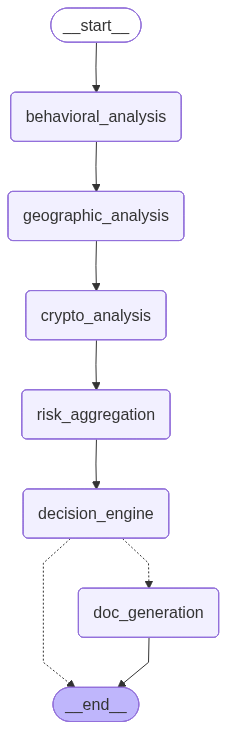

In [67]:
from IPython.display import Image, display

app = build_dynamic_routing_graph()
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [68]:
def main(test: bool = True):
    """
    Main function to run the AML transaction monitoring system.
    
    Args:
        test: If True, runs on a small sample. If False, processes full dataset.
    
    Returns:
        tuple: (compiled_app, results_dataframe)
    """
    logger.info("Starting AML Transaction Monitoring System")
    
    # Build the workflow application
    app = build_dynamic_routing_graph()
    
    # Determine batch size based on test mode
    if test:
        batch_size = 10
        sample_transactions = trx.head(50)
        logger.info(f"Test mode: Processing {len(sample_transactions)} transactions")
    else:
        batch_size = 100
        sample_transactions = trx
        logger.info(f"Full mode: Processing {len(sample_transactions)} transactions")
    
    # Process transactions
    results = []
    errors = []
    
    logger.info(f"Processing transactions in batches of {batch_size}")
    
    for i in range(0, len(sample_transactions), batch_size):
        batch = sample_transactions.iloc[i:i+batch_size]
        batch_num = (i // batch_size) + 1
        total_batches = ((len(sample_transactions) - 1) // batch_size) + 1
        
        logger.info(f"Processing batch {batch_num}/{total_batches} ({len(batch)} transactions)")
        
        for idx, (_, row) in enumerate(batch.iterrows()):
            try:
                # Get customer data
                customer_row = customers[customers["customer_id"] == row["customer_id"]]
                if customer_row.empty:
                    logger.warning(f"Customer {row['customer_id']} not found, skipping transaction {row['trx_id']}")
                    continue
                
                customer_data = customer_row.iloc[0]
                
                # Get crypto data if available
                crypto_data = None
                crypto_row = crypto[crypto["customer_id"] == row["customer_id"]]
                if not crypto_row.empty:
                    crypto_data = crypto_row.iloc[0]
                
                # Create transaction and customer objects
                txn = make_txn_event(row)
                customer = Customer(**customer_data.to_dict())
                crypto_obj = Crypto(**crypto_data.to_dict()) if crypto_data is not None else None
                
                # Initialize state
                initial_state = AMLState(
                    txn=txn,
                    customer=customer,
                    crypto=crypto_obj,
                    logs=[f"Transaction {txn.trx_id} processing started"]
                )
                
                # Process through workflow
                final_state = app.invoke(
                    {"case": initial_state},
                    config={"configurable": {"thread_id": f"txn-{txn.trx_id}"}}
                )
                
                case = final_state["case"]
                
                # Collect results
                result = {
                    "trx_id": case.txn.trx_id,
                    "customer_id": case.txn.customer_id,
                    "amount": case.txn.amount,
                    "currency": case.txn.currency,
                    "trx_type": case.txn.trx_type,
                    "timestamp": case.txn.timestamp,
                    "behavior_score": case.behavior_risk.score if case.behavior_risk else 0,
                    "behavior_reason": case.behavior_risk.reason if case.behavior_risk else "",
                    "geo_score": case.geo_risk.score if case.geo_risk else 0,
                    "geo_reason": case.geo_risk.reason if case.geo_risk else "",
                    "crypto_score": case.crypto_risk.score if case.crypto_risk else 0,
                    "crypto_reason": case.crypto_risk.reason if case.crypto_risk else "",
                    "final_score": case.final_risk_score or 0,
                    "risk_level": case.risk_level or "LOW",
                    "requires_doc": case.requires_doc or False,
                    "next_action": case.next_action or "standard_processing",
                    "typology": case.typology or "None",
                    "processing_complete": case.processing_complete or False,
                    "has_report": case.report is not None
                }
                
                results.append(result)
                
                # Log high-risk cases
                if case.final_risk_score and case.final_risk_score >= 60:
                    logger.info(f"High-risk transaction detected: {txn.trx_id} (Score: {case.final_risk_score})")
                
            except Exception as e:
                error_msg = f"Error processing transaction {row.get('trx_id', 'UNKNOWN')}: {str(e)}"
                logger.error(error_msg)
                errors.append({
                    "trx_id": row.get("trx_id", "UNKNOWN"),
                    "customer_id": row.get("customer_id", "UNKNOWN"),
                    "error": str(e),
                    "error_type": type(e).__name__
                })
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    
    # Display summary statistics
    if len(results_df) > 0:
        high_risk_count = len(results_df[results_df["risk_level"].isin(["HIGH", "EXTREME"])])
        medium_risk_count = len(results_df[results_df["risk_level"] == "MEDIUM"])
        requires_doc_count = results_df["requires_doc"].sum()
        
        rprint(f"\n[bold green]Processing Complete![/bold green]")
        rprint(f"Total transactions processed: [cyan]{len(results_df)}[/cyan]")
        rprint(f"High/Extreme risk cases: [red]{high_risk_count}[/red]")
        rprint(f"Medium risk cases: [yellow]{medium_risk_count}[/yellow]")
        rprint(f"Documentation required: [orange3]{requires_doc_count}[/orange3]")
        rprint(f"Processing errors: [red]{len(errors)}[/red]")
        
        if high_risk_count > 0:
            rprint(f"\n[bold red]High Risk Cases Summary:[/bold red]")
            high_risk_cases = results_df[results_df["risk_level"].isin(["HIGH", "EXTREME"])]
            display_cols = ["trx_id", "amount", "final_score", "risk_level", "next_action", "typology"]
            display(high_risk_cases[display_cols].head(10))
        
        # Show risk score distribution
        if len(results_df) > 5:
            rprint(f"\n[bold cyan]Risk Score Distribution:[/bold cyan]")
            score_bins = pd.cut(results_df["final_score"], bins=[0, 20, 40, 60, 80, 100], 
                              labels=["Very Low", "Low", "Medium", "High", "Very High"])
            score_dist = score_bins.value_counts().sort_index()
            for level, count in score_dist.items():
                rprint(f"{level}: {count} transactions")
        
        # Show top typologies
        if results_df["typology"].notna().any():
            rprint(f"\n[bold cyan]Top Risk Typologies:[/bold cyan]")
            typology_counts = results_df["typology"].value_counts().head(5)
            for typology, count in typology_counts.items():
                rprint(f"{typology}: {count} cases")
    
    else:
        rprint("[yellow]No transactions were successfully processed![/yellow]")
    
    # Display errors if any
    if errors:
        rprint(f"\n[bold red]Processing Errors ({len(errors)}):[/bold red]")
        error_df = pd.DataFrame(errors)
        display(error_df.head())
    
    logger.info("AML processing completed successfully")
    
    return app, results_df


if __name__ == "__main__":
    # Toggle between test (True) or full run (False)
    app, results = main(test=True)

2025-11-09 21:07:25,171 [INFO] Starting AML Transaction Monitoring System
2025-11-09 21:07:25,183 [INFO] Test mode: Processing 50 transactions
2025-11-09 21:07:25,186 [INFO] Processing transactions in batches of 10
2025-11-09 21:07:25,188 [INFO] Processing batch 1/5 (10 transactions)
2025-11-09 21:07:25,183 [INFO] Test mode: Processing 50 transactions
2025-11-09 21:07:25,186 [INFO] Processing transactions in batches of 10
2025-11-09 21:07:25,188 [INFO] Processing batch 1/5 (10 transactions)
c:\Users\AntónioJaneiro\workspace\AgenticApplications-Cohort-1\langchain_assignment\.venv\Lib\site-packages\pydantic\main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=False, input_type=bool])
  return self.__pydantic_serializer__.to_python(
c:\Users\AntónioJaneiro\workspace\AgenticApplications-Cohort-1\langchain_assignment\.venv\Lib\site-packages\pydantic\main.py:463: UserWarning: Pydan

Processing Complete!

Total transactions processed: 50

High/Extreme risk cases: 0

Medium risk cases: 0

Documentation required: 0

Processing errors: 0

Risk Score Distribution:

Very Low: 0 transactions

Low: 50 transactions

Medium: 0 transactions

High: 0 transactions

Very High: 0 transactions

Top Risk Typologies:

General Suspicious Activity: 50 cases

2025-11-09 21:07:25,978 [INFO] AML processing completed successfully
